In [63]:
import glob
import os.path
import random

from astropy.io import fits
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

import read_data
import tools

# Image Order
C, I1, I2, I3, R

filestem.C.fits = coadded subtractedimages<br/>
filestem.I?.fits = the three individual subtracted images<br/>
filestem.R.fits = reference image<br/>
# Classifications 'RTYPE'
0 = variable star<br/>
1 = asteroid<br/>
2 = transient<br/>
3 = possible variable<br/>
4 = unknown classification<br/>
5 = some kind of bright star artifact -- can be either the core of the
        or a diffraction spike artifact<br/>
6 = some other kind of artifact<br/>
<br/>
so essentially 0/1/2 are all realy things, 5/6 are really not things,
3/4 are uncertain

# Read in data from fits and save in numpy format for quicker reloading

In [12]:
X, rfc, y = read_data.get_raw_data()

Restoring X and y from Xy_raw.npz
Done


# Histograms of minimum and maximum values of all 5 images

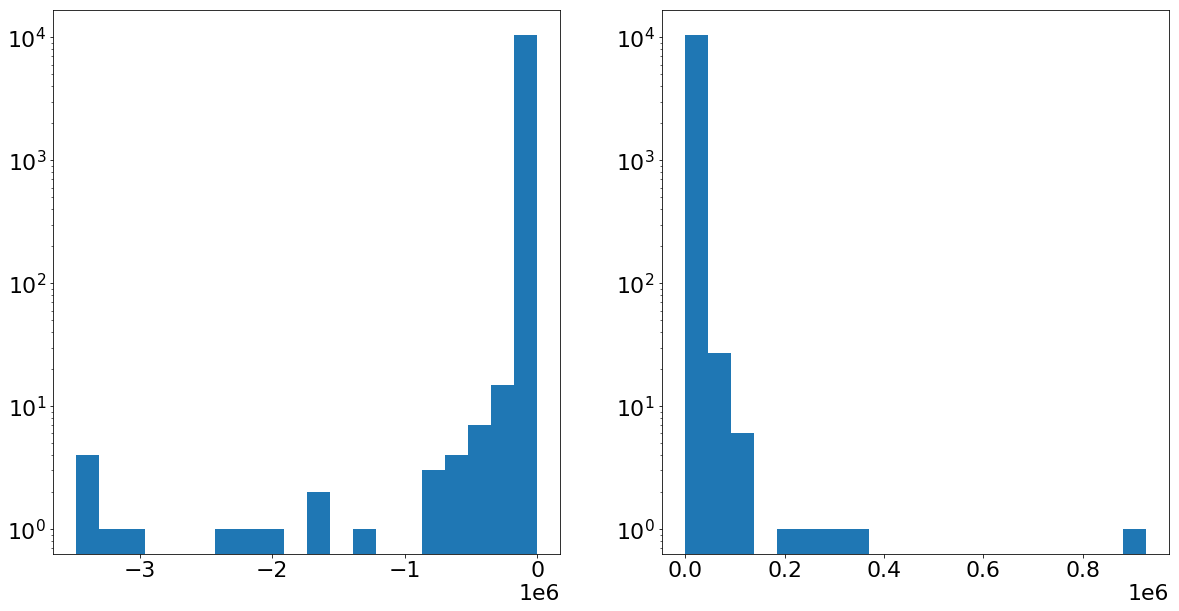

In [12]:
image = X[:,0]
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 22})
plt.subplot(1, 2, 1)
plt.hist(image.min((1,2)), bins=20, log=True)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.subplot(1, 2, 2)
plt.hist(image.max((1,2)), bins=20, log=True);
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

# Display set of images for a random example

class 6


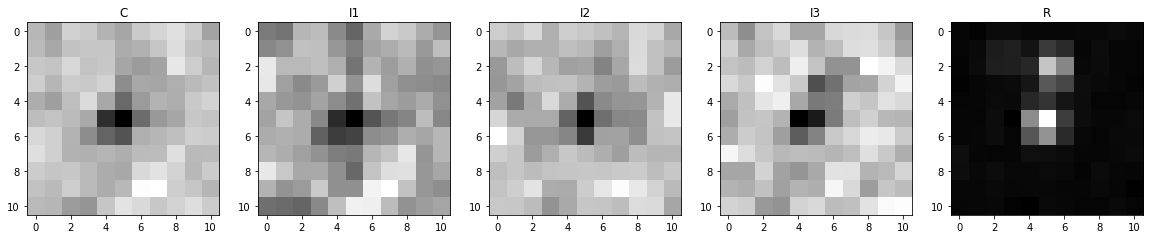

In [25]:
plt.figure(figsize=(20,10))
titles = ['C', 'I1', 'I2', 'I3', 'R']
example = random.randrange(len(X))
print('class', y[example])
for i, title in enumerate(titles):
    plt.subplot(1, 5, i+1)
    plt.title(title)
    plt.imshow(X[example,i], cmap='gray')

# Histogram of class labels

(array([ 4125.,  1554.,  1015.,  1066.,   598.,  1229.,   930.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5]),
 <a list of 7 Patch objects>)

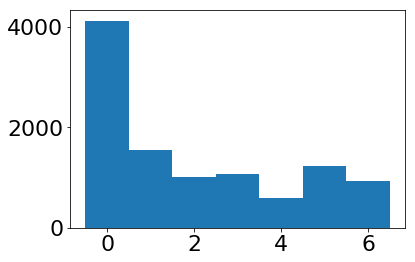

In [5]:
plt.hist(y, bins=np.arange(8)-0.5)

# Split into train and validation sets

Gathering more data is easy so a test set is not being withheld. Also no data normalization is done since the first experiments will not need it.

In [3]:
random_state = 0

# flatten data and split
X_train, X_test, y_train, y_test = train_test_split(X.reshape(X.shape[0], -1), y, test_size=0.2,
                                                    random_state=random_state)

# XGBoost Experiments

## Default Parameters and all 500 image features

In [5]:
clf = XGBClassifier()
%time clf.fit(X_train, y_train)

CPU times: user 5min 34s, sys: 2.43 s, total: 5min 36s
Wall time: 48.6 s


XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [7]:
clf.score(X_test, y_test)

0.58887832699619769

Confusion matrix, without normalization
[[730  52   5   4  23   9   3]
 [ 18 260   5   0   7   0   1]
 [102  71  41   1   9   5   1]
 [161  15   2   5  13   4   1]
 [ 19  36   2   0  51   3   4]
 [ 81  15   1   4   6 142   5]
 [106  23   1   1  15  31  10]]


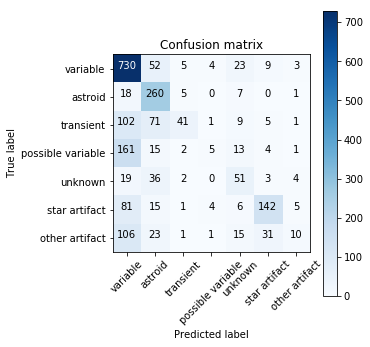

In [14]:
y_pred = clf.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,5))
classes=['variable','astroid','transient','possible variable','unknown','star artifact','other artifact']
tools.plot_confusion_matrix(cnf_matrix, classes=classes, normalize=False);

## Images cropped to 7x7

In [54]:
size_7x7 = X[:,:,2:-2,2:-2].reshape(len(X), -1) # center crop 7x7 of 11x11 images

X_train, X_test, y_train, y_test = train_test_split(size_7x7, y, test_size=0.2,
                                                    random_state=random_state)
X_train.shape

(8413, 245)

In [55]:
clf = XGBClassifier()
%time clf.fit(X_train, y_train)

CPU times: user 2min 5s, sys: 1.68 s, total: 2min 7s
Wall time: 18.6 s


XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [56]:
clf.score(X_test, y_test)

0.59743346007604559

Confusion matrix, without normalization
[[743  42   5   3  21   8   4]
 [ 18 258   4   0  11   0   0]
 [102  69  41   3   9   6   0]
 [157  11   5   6  16   4   2]
 [ 19  33   0   1  55   4   3]
 [ 78  12   1   5   6 148   4]
 [105  25   0   3  17  31   6]]


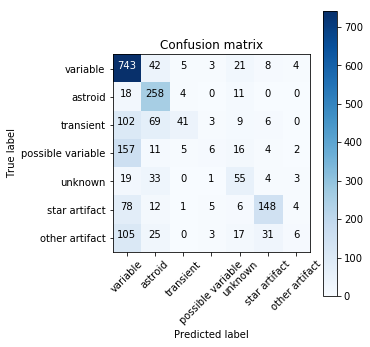

In [57]:
y_pred = clf.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,5))
classes=['variable','astroid','transient','possible variable','unknown','star artifact','other artifact']
tools.plot_confusion_matrix(cnf_matrix, classes=classes, normalize=False);

# Test removing coadded images

In [59]:
size_7x7 = X[:,1:,2:-2,2:-2].reshape(len(X), -1) # exclude first image and center crop 7x7 of 11x11 images

X_train, X_test, y_train, y_test = train_test_split(size_7x7, y, test_size=0.2,
                                                    random_state=random_state)
X_train.shape

(8413, 196)

In [60]:
clf = XGBClassifier()
%time clf.fit(X_train, y_train)

CPU times: user 1min 44s, sys: 1.67 s, total: 1min 46s
Wall time: 15.3 s


XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [61]:
clf.score(X_test, y_test)

0.59077946768060841

Confusion matrix, without normalization
[[738  43   2   6  24  11   2]
 [ 14 263   3   0  11   0   0]
 [103  71  38   2  11   5   0]
 [164  12   5   2  12   4   2]
 [ 19  40   0   1  51   2   2]
 [ 81  14   1   3   4 148   3]
 [109  22   0   3  20  30   3]]


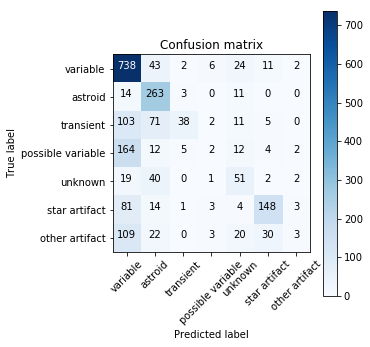

In [62]:
y_pred = clf.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,5))
classes=['variable','astroid','transient','possible variable','unknown','star artifact','other artifact']
tools.plot_confusion_matrix(cnf_matrix, classes=classes, normalize=False);